In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data as mnist_data

In [3]:
tf.__version__

'1.2.1'

In [4]:
sess = tf.InteractiveSession()

In [5]:
mnist = mnist_data.read_data_sets("/home/tiao/Desktop/MNIST")

Extracting /home/tiao/Desktop/MNIST/train-images-idx3-ubyte.gz
Extracting /home/tiao/Desktop/MNIST/train-labels-idx1-ubyte.gz
Extracting /home/tiao/Desktop/MNIST/t10k-images-idx3-ubyte.gz
Extracting /home/tiao/Desktop/MNIST/t10k-labels-idx1-ubyte.gz


In [6]:
# 50 single-channel (grayscale) 28x28 images
x = mnist.train.images[:50].reshape(-1, 28, 28, 1)
x.shape

(50, 28, 28, 1)

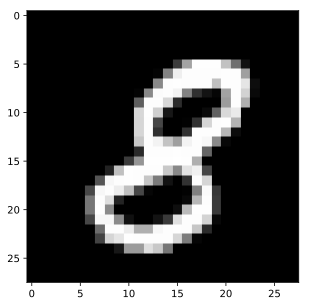

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

# showing an arbitrarily chosen image
ax.imshow(np.squeeze(x[5], axis=-1), cmap='gray')

plt.show()

### Standard 2D Convolution with `conv2d`

In [8]:
# 32 kernels of size 5x5x1
kernel = tf.truncated_normal([5, 5, 1, 32], stddev=0.1)
kernel.get_shape().as_list()

[5, 5, 1, 32]

In [9]:
x_conved = tf.nn.conv2d(x, kernel, 
                        strides=[1, 1, 1, 1], 
                        padding='SAME')
x_conved.get_shape().as_list()

[50, 28, 28, 32]

In [10]:
x_conved[5, ..., 0].eval().shape

(28, 28)

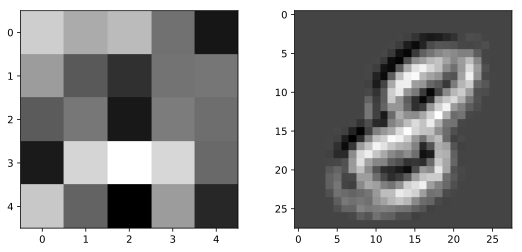

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

# showing what the 0th filter looks like
ax1.imshow(kernel[..., 0, 0].eval(), cmap='gray')

# show the previous arbitrarily chosen image
# convolved with the 0th filter
ax2.imshow(x_conved[5, ..., 0].eval(), cmap='gray')

plt.show()

## Sample from a Distribution over Kernels

In [12]:
# 8x32 kernels of size 5x5x1
kernels = tf.truncated_normal([8, 5, 5, 1, 32], stddev=0.1)
kernels.get_shape().as_list()

[8, 5, 5, 1, 32]

### Approach 1: Map over samples with `conv2d`

In [13]:
x_tiled = tf.tile(tf.expand_dims(x, 0), [8, 1, 1, 1, 1])
x_tiled.get_shape().as_list()

[8, 50, 28, 28, 1]

In [19]:
tf.nn.conv2d(x_tiled[0], kernels[0], 
             strides=[1, 1, 1, 1], 
             padding='SAME').get_shape().as_list()

[50, 28, 28, 32]

In [15]:
x_conved1 = tf.map_fn(lambda args: tf.nn.conv2d(*args, strides=[1, 1, 1, 1], padding='SAME'),
                      elems=(x_tiled, kernels), dtype=tf.float32)
x_conved1.get_shape().as_list()

[8, 50, 28, 28, 32]

### Approach 2: Flattening

In [16]:
kernels_flat = tf.reshape(tf.transpose(kernels, 
                                       perm=(1, 2, 3, 4, 0)), 
                          shape=(5, 5, 1, 32*8))
kernels_flat.get_shape().as_list()

[5, 5, 1, 256]

In [17]:
x_conved2 = tf.transpose(tf.reshape(tf.nn.conv2d(x, kernels_flat, 
                                                 strides=[1, 1, 1, 1], 
                                                 padding='SAME'), 
                                    shape=(50, 28, 28, 32, 8)), 
                         perm=(4, 0, 1, 2, 3))
x_conved2.get_shape().as_list()

[8, 50, 28, 28, 32]

In [18]:
tf.reduce_all(tf.equal(x_conved1, x_conved2)).eval()

True